In [498]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer
from sklearn.compose import ColumnTransformer
from scipy.optimize import curve_fit
import math
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer
import numpy as np

In [499]:
class Plot_data:
    def __init__(self, data):
        self.data = data

In [500]:
def sgd_train(x_train, y_train):
    sgd_regressor = make_pipeline(StandardScaler(),SGDRegressor(loss='squared_error',max_iter=1000, alpha=0.0001, learning_rate='invscaling', random_state=42))
    # sgd_regressor = SGDRegressor(loss='squared_error',
    #                              max_iter=1000, alpha=0.0001, 
    #                              learning_rate='invscaling', 
    #                              random_state=42)
    sgd_regressor.fit(x_train, y_train.values.ravel())
    model = sgd_regressor
    score = cross_val_score(sgd_regressor, x_train, y_train.values.ravel(), cv=10, scoring='neg_root_mean_squared_error').mean().round(2)
    print("Cross val score is",score)
    return model

In [501]:
def sgd_pred(data,model):
    output = model.predict(data)
    return output

In [502]:
def plot(data):
    x_test  = data.x_test
    y_pred  = data.y_pred
    x_train = data.x_train
    y_train = data.y_train

    plt.scatter(x_train, y_train)
    plt.scatter(x_test, y_pred)
    plt.title("ML result")
    plt.xlabel("flown distance (nm)")
    plt.ylabel("tow (kg)")
    plt.show()

In [503]:
def plot_residual(data):
    x_test  = data.x_test
    y_diff  = data.y_pred - data.y_train

    plt.scatter(x_test, y_diff)
    plt.title("ML result")
    plt.xlabel("flown distance (nm)")
    plt.ylabel("tow (kg)")
    plt.show()

In [504]:
def man_sgd(train_df,submi_df,acft):

    x = train_df.loc[train_df['aircraft_type'] == acft,['flown_distance']]    
    x_submi = submi_df.loc[:,['flown_distance']] 

    y = train_df.loc[train_df['aircraft_type'] == acft,['tow']]
    print(acft,"dataframe size is",x.size)

    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size=0.2, 
                                                        random_state=42)

    print("The x_train size is",x_train.size)
    print("The y_train size is",y_train.size)
    # model = train(train_df)
    model = sgd_train(x_train,y_train)
    # output = pred(submi_df,model)
    y_pred = sgd_pred(x_test,model)
    Plot_data.x_test  = x_test  
    Plot_data.y_pred  = y_pred  
    Plot_data.x_train = x_train 
    Plot_data.y_train = y_train 
    plot(Plot_data)

In [505]:
def auto_cat_quad_sgd(train_df,submi_df,acftplot):
    train_df_narrow = train_df[['airline','aircraft_type','flown_distance']]
    # train_df_narrow.loc[:,"tag"] = 'train'
    submi_df_narrow = submi_df[['airline','aircraft_type','flown_distance']]
    # submi_df_narrow.loc[:,"tag"] = 'submi'
    joint_df_narrow = pd.concat([train_df_narrow,submi_df_narrow])
    # print(joint_df_narrow)
    # poly = PolynomialFeatures(degree=2,include_bias=True)
    # X_test_trans = poly.transform(X_test)

    t = ColumnTransformer(
            transformers=[('onehot', OneHotEncoder(), ['airline','aircraft_type']),
                          ('scaled_poly', Pipeline(steps=[('scale', StandardScaler()),
                                                          ('Poly',PolynomialFeatures(degree=2, include_bias=True))]) , ['flown_distance'])                                        
                         ], remainder='passthrough')
    
    # t = ColumnTransformer([('onehot', OneHotEncoder(), ['airline','aircraft_type']),
    #                        ('scaled_poly', Pipeline(steps=[('scale', StandardScaler()),
    #                                                        ('Poly',PolynomialFeatures(degree=2, include_bias=True))]) , ['flown_distance']),                                      
    #                        ('skip','passthrough',['tag'])])
    
    # t = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), ['airline','aircraft_type']),
    #                                     ('scaled_sqrt', Pipeline(steps=[('scale', StandardScaler()),
    #                                                                    ('sqrt',FunctionTransformer(np.sqrt))]),
    #                                                                    ['flown_distance'])
    #                                     ], remainder='passthrough')

    # t = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), ['airline','aircraft_type']),
    #                                     ('scale', StandardScaler(), ['flown_distance']),        
    #                                     ], remainder='passthrough')
    
    # t_y = ColumnTransformer(transformers=[('poly', PolynomialFeatures(),['tow'])])
    # Transform the features
    features = t.fit_transform(train_df_narrow)
    joint_features = t.fit_transform(joint_df_narrow)
    # print(joint_features)
    features = joint_features[0:369013,:]
    submi_features = joint_features[369013:,:]
    # print(features[-1,:])

    result = train_df['tow']
    # result = t_y.fit_transform(train_df['tow'])

    # Train the linear regression model
    reg = LinearRegression()
    model = reg.fit(features, result)
    # model = reg.fit(features, result)
    score = cross_val_score(model, features, result.values.ravel(), cv=10, scoring='neg_root_mean_squared_error').mean().round(2)
    print("Cross val score is",score)

    pred  = model.predict(features)
    pred_submi  = model.predict(submi_features)
    print(pred_submi)
    if acftplot == "all":
        Plot_data.x_test  = train_df_narrow.loc[:,['flown_distance']]   
        Plot_data.y_pred  = model.predict(features)  
        Plot_data.x_train = train_df_narrow.loc[:,['flown_distance']] 
        Plot_data.y_train = result 
    else:
        Plot_data.x_test  = train_df_narrow.loc[train_df['aircraft_type'] == acftplot,['flown_distance']]   
        Plot_data.y_pred  = pred[train_df['aircraft_type'] == acftplot]
        Plot_data.x_train = train_df_narrow.loc[train_df['aircraft_type'] == acftplot,['flown_distance']] 
        Plot_data.y_train = result.loc[train_df['aircraft_type'] == acftplot]    

    residual = model.predict(features) - result

    # plot(Plot_data)
    # plot_residual(Plot_data)

    return model, pred_submi, residual

In [506]:
def objective(n, a, b, c):
	return a * np.sqrt(n+b) + c

In [507]:
def auto_cat_curve(train_df,submi_df,acftplot):
    x_submi = submi_df.loc[submi_df['aircraft_type'] == 'B738',['flown_distance']]
    # train_df_narrow = train_df[['airline','aircraft_type','flown_distance']]
    # # train_df_narrow.loc[:,"tag"] = 'train'
    # submi_df_narrow = submi_df[['airline','aircraft_type','flown_distance']]
    # # submi_df_narrow.loc[:,"tag"] = 'submi'
    # joint_df_narrow = pd.concat([train_df_narrow,submi_df_narrow])
    # # print(joint_df_narrow)
    # # poly = PolynomialFeatures(degree=2,include_bias=True)
    # # X_test_trans = poly.transform(X_test)

    # t = ColumnTransformer(
    #         transformers=[('onehot', OneHotEncoder(), ['airline','aircraft_type']),
    #                       ('scaled_poly', Pipeline(steps=[('scale', StandardScaler()),
    #                                                       ('Poly',PolynomialFeatures(degree=1, include_bias=True))]) , ['flown_distance'])                                        
    #                      ], remainder='passthrough')
    # x_submi = submi_df.loc[:,['flown_distance']]   
    x = train_df.loc[train_df['aircraft_type'] == 'B738',['flown_distance']]
    y = train_df.loc[train_df['aircraft_type'] == 'B738',['tow']]
    # t = ColumnTransformer([('onehot', OneHotEncoder(), ['airline','aircraft_type']),
    #                        ('scaled_poly', Pipeline(steps=[('scale', StandardScaler()),
    #                                                        ('Poly',PolynomialFeatures(degree=2, include_bias=True))]) , ['flown_distance']),                                      
    #                        ('skip','passthrough',['tag'])])
    
    # t = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), ['airline','aircraft_type']),
    #                                     ('scaled_sqrt', Pipeline(steps=[('scale', StandardScaler()),
    #                                                                    ('sqrt',FunctionTransformer(np.sqrt))]),
    #                                                                    ['flown_distance'])
    #                                     ], remainder='passthrough')

    # t = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), ['airline','aircraft_type']),
    #                                     ('scale', StandardScaler(), ['flown_distance']),        
    #                                     ], remainder='passthrough')
    
    # t_y = ColumnTransformer(transformers=[('poly', PolynomialFeatures(),['tow'])])
    # Transform the features
    # features = t.fit_transform(train_df_narrow)
    # joint_features = t.fit_transform(joint_df_narrow)
    # # print(joint_features)
    # features = joint_features[0:369013,:]
    # submi_features = joint_features[369013:,:]
    # print(features[-1,:])
    x = x.values.flatten()
    y = y.values.flatten()
    
    # result = t_y.fit_transform(train_df['tow'])

    # fit the curve function
    popt, _ = curve_fit(objective, x, y)
    a, b, c = popt
    print('y = %.5f * sqrt(x+ %.5f) + %.5f' % (a,b,c))
    y_pred = objective(x_submi,a,b,c)

    plt.scatter(x, y)
    plt.scatter(x_submi, y_pred)
    plt.title("ML result")
    plt.xlabel("flown distance (nm)")
    plt.ylabel("tow (kg)")
    plt.show()

In [508]:
def auto_cat_sgd(train_df,submi_df,acftplot):
    train_df_narrow = train_df[['airline','aircraft_type','flown_distance']]
    t = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), ['airline','aircraft_type']),
                                        ('scale', StandardScaler(), ['flown_distance'])                                        
                                        ], remainder='passthrough')

    # Transform the features
    features = t.fit_transform(train_df_narrow)
    result = train_df['tow']

    # Train the linear regression model
    reg = LinearRegression()
    model = reg.fit(features, result)
    score = cross_val_score(model, features, result.values.ravel(), cv=10, scoring='neg_root_mean_squared_error').mean().round(2)
    print("Cross val score is",score)

    pred  = model.predict(features)
    if acftplot == "all":
        Plot_data.x_test  = train_df_narrow.loc[:,['flown_distance']]   
        Plot_data.y_pred  = model.predict(features)  
        Plot_data.x_train = train_df_narrow.loc[:,['flown_distance']] 
        Plot_data.y_train = result 
    else:
        Plot_data.x_test  = train_df_narrow.loc[train_df['aircraft_type'] == acftplot,['flown_distance']]   
        Plot_data.y_pred  = pred[train_df['aircraft_type'] == acftplot]
        Plot_data.x_train = train_df_narrow.loc[train_df['aircraft_type'] == acftplot,['flown_distance']] 
        Plot_data.y_train = result.loc[train_df['aircraft_type'] == acftplot]    

    plot(Plot_data)
    plot_residual(Plot_data)

In [509]:
def man_poly(train_df,submi_df,acft):
    
    x_submi = submi_df.loc[:,['flown_distance']]   
    x = train_df.loc[train_df['aircraft_type'] == acft,['flown_distance']]
    y = train_df.loc[train_df['aircraft_type'] == acft,['tow']]
    print(x.loc[x['flown_distance']<0])
    print("run pass")
    sgd_regressor = make_pipeline(StandardScaler(),FunctionTransformer(np.sqrt),SGDRegressor(loss='squared_error',max_iter=1000, alpha=0.0001, learning_rate='invscaling', random_state=42))
    model = sgd_regressor.fit(x, y.values.ravel())
    features = x
    result = y
    # t = ColumnTransformer(transformers=[('scaled_sqrt', Pipeline(steps=[('scale', StandardScaler())]),
    #                                                                     # ('sqrt',FunctionTransformer(np.sqrt))]),
    #                                                     ['flown_distance'])
    #                                     ], remainder='passthrough')

    # Transform the features
    # features = t.fit_transform(x)
    # print(features)
    # result = y
    # # result = t_y.fit_transform(train_df['tow'])

    # # Train the linear regression model
    # reg = LinearRegression()
    # # reg = SGDRegressor(loss='squared_error',max_iter=1000, alpha=0.0001, learning_rate='invscaling', random_state=42)
    # model = reg.fit(features, result)
    score = cross_val_score(model, features, result.values.ravel(), cv=10, scoring='neg_root_mean_squared_error').mean().round(2)
    print("Cross val score is",score)

    # output = pred(submi_df,model)
    y_pred = model.predict(x)
    Plot_data.x_test  = x  
    Plot_data.y_pred  = y_pred  
    Plot_data.x_train = x 
    Plot_data.y_train = y 
    plot(Plot_data)
    
    return model

In [510]:
def man_krr(train_df,submi_df,acft):

    x = train_df.loc[train_df['aircraft_type'] == acft,['flown_distance']]    

    y = train_df.loc[train_df['aircraft_type'] == acft,['tow']]
    print(acft,"dataframe size is",x.size)

    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size=0.9, 
                                                        random_state=42)

    print("The x_train size is",x_train.size)
    print("The y_train size is",y_train.size)
    # model = train(train_df)
    krr = make_pipeline(StandardScaler(),KernelRidge(alpha=0.001))
    # sgd_regressor = SGDRegressor(loss='squared_error',
    #                              max_iter=1000, alpha=0.0001, 
    #                              learning_rate='invscaling', 
    #                              random_state=42)
    krr.fit(x_train, y_train.values.ravel())
    model = krr
    score = cross_val_score(krr, x_train, y_train.values.ravel(), cv=10, scoring='neg_root_mean_squared_error').mean().round(2)
    print("Cross val score is",score)

    # output = pred(submi_df,model)
    y_pred = sgd_pred(x,model)
    Plot_data.x_test  = x  
    Plot_data.y_pred  = y_pred  
    Plot_data.x_train = x 
    Plot_data.y_train = y 
    plot(Plot_data)

In [511]:
def auto_cat_krr(train_df,submi_df,acftplot):
    train_df_narrow = train_df[['airline','aircraft_type','flown_distance']]
    t = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), ['airline','aircraft_type']),
                                        ('scale', StandardScaler(), ['flown_distance'])                                        
                                        ], remainder='passthrough')

    # Transform the features
    features = t.fit_transform(train_df_narrow)
    result = train_df['tow']

    # Train the linear regression model
    krr = KernelRidge(alpha=1.0)
    model = krr.fit(features, result)
    score = cross_val_score(model, features, result.values.ravel(), cv=10, scoring='neg_root_mean_squared_error').mean().round(2)
    print("Cross val score is",score)

    # pred  = model.predict(features)
    # Plot_data.x_test  = train_df_narrow.loc[train_df['aircraft_type'] == acftplot,['flown_distance']]   
    # Plot_data.y_pred  = pred[train_df['aircraft_type'] == acftplot]
    # Plot_data.x_train = train_df_narrow.loc[train_df['aircraft_type'] == acftplot,['flown_distance']] 
    # Plot_data.y_train = result.loc[train_df['aircraft_type'] == acftplot]    
    # plot(Plot_data)

    Plot_data.x_test  = train_df_narrow.loc[:,['flown_distance']]   
    Plot_data.y_pred  = model.predict(features)  
    Plot_data.x_train = train_df_narrow.loc[:,['flown_distance']] 
    Plot_data.y_train = result 
    plot(Plot_data)

In [512]:
def __main__():
    train_df = pd.read_csv("challenge_set.csv") 
    submi_in_df = pd.read_csv("final_submission_set.csv") 
    print("The entire dataframe size is",train_df.size)
    submi_in_df.loc[submi_in_df['airline']=='e5b13da1511ff741c34c94cfd5575c55',['airline']] = '6351ec1b849adacc0cbb3b1313d8d39b'

    ## Manual Catgorising with just One Operator
    # acft = 'A320'
    # man_poly(train_df,submi_in_df,acft)
    # man_sgd(train_df,submi_in_df,acft)
    # man_krr(train_df,submi_in_df,acft)

    ## Auto Catgorising using One Hot Encoder
    acftplot = 'B738'
    # auto_cat_sgd(train_df,submi_in_df,acftplot)
    # model, pred_submi, residual = auto_cat_quad_sgd(train_df,submi_in_df,acftplot)
    auto_cat_curve(train_df,submi_in_df,acftplot)
    # auto_cat_krr(train_df,submi_df,acftplot)
    
    ## Export final submission set    
    # residual_df = pd.DataFrame()
    # residual_df["flight_id"] = train_df['flight_id']
    # residual_df["residual"] = residual
    # print(residual_df)
    # residual_df.to_csv("residuals.csv")

    # submi_set_df = pd.DataFrame()
    # submi_set_df['flight_id'] = submi_in_df['flight_id']
    # submi_set_df['tow'] = pred_submi
    # print(submi_set_df)
    # submi_set_df.to_csv("submi_set.csv")

The entire dataframe size is 6642234


C:\Users\yrrej\AppData\Local\Temp\ipykernel_5460\3086516544.py:2: RuntimeWarning: invalid value encountered in sqrt
  return a * np.sqrt(n+b) + c


y = 245.94101 * sqrt(x+ -25.00000) + 58246.87926


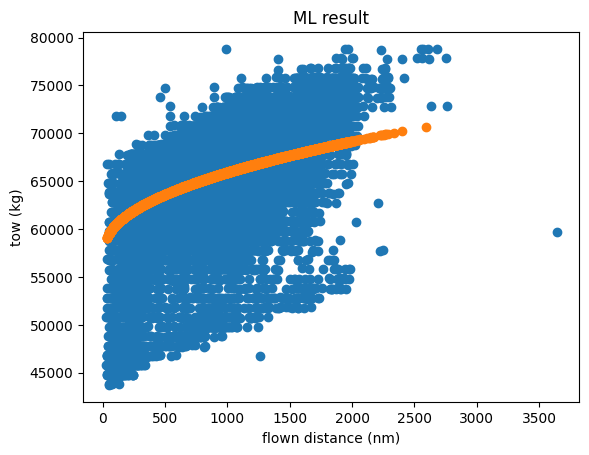

In [513]:
__main__()